<a href="https://colab.research.google.com/github/khandakerrahin/BOVW/blob/main/BOVW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We start by mounting our drive folder so that we can access our data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install opencv-python -U
!pip install umap-learn

     |████████████████████████████████| 60.5 MB 1.2 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 86 kB 3.6 MB/s 
     |████████████████████████████████| 1.1 MB 51.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=a757334ac18f9ff683c0cc10dce3a9f58940cd601406e2676118f7d7bc67843c
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=09

This mnist is already in the format of class/image.png

In [ ]:
!unzip "/content/drive/MyDrive/mnist.zip"

Archive:  /content/drive/MyDrive/mnist.zip
replace mnist/train/0/1000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


The general structure of what we want to do is something like:

- Load the train and test images
- Extract some descriptors from all images. Here we are going to use an algorithm called SIFT/ORF
- Generate visual words by applying k-means to the SIFT/ORF descriptors of the train data
- Extract an histogram of the visual words from train and test data (effectively generating our features)
- Training a ML algorithm
- Apply it to test data and evaluate 

In [ ]:
import os  # OS, dealing with file stuff, OS
import cv2  # opencv, images library
import numpy as np # vector, matrices
from tqdm import tqdm # progress bar
from pathlib import Path # path-related stuff
import matplotlib.pyplot as plt # plotting
import umap  # T-SNE / UMAP
import pandas as pd # dataframes
import seaborn as sns  # plotting
from sklearn.svm import SVC # svm
from sklearn.ensemble import RandomForestClassifier # random forest
from sklearn.metrics import accuracy_score  # just accuracy

In [ ]:
# let's start by loading data
def load_imgs(folder, grayscale=True):
    images = []
    for f in tqdm(os.listdir(folder)):      
        f = os.path.join(folder, f)
        img = cv2.imread(f, 3)
        # convert to grayscale
        if grayscale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return images

base_folder = Path('mnist')

train_imgs = [
    (img, y)
    for y in os.listdir(base_folder / 'train')
    for img in load_imgs(base_folder / 'train' / y)[:100]
]  # list comprehension

# train_imgs = []
# for y in os.listdir(base_folder / 'train'):
#     for img in load_imgs(base_folder / 'train' / y)[:100]:
#         train_imgs.append((img, y))


test_imgs = [
    (img, y)
    for y in os.listdir(base_folder / 'valid')
    for img in load_imgs(base_folder / 'valid' / y)[:100]
]

100%|██████████| 982/982 [00:00<00:00, 16791.03it/s]


In [ ]:
print(len(train_imgs))
print(len(test_imgs))
print(train_imgs[0])

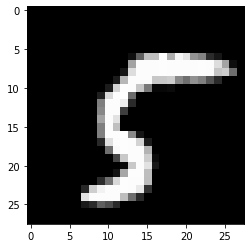

In [ ]:
plt.imshow(train_imgs[0][0], cmap='gray')

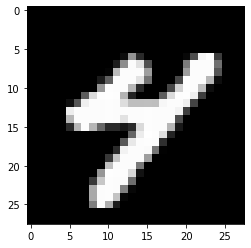

In [ ]:
plt.imshow(train_imgs[999][0], cmap='gray')

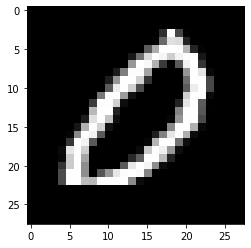

In [ ]:
plt.imshow(train_imgs[200][0], cmap='gray')

Now we are going to extract the descriptors of each image. The algorithm will extract some keypoints from the image, and then, for each keypoint, it's going represent it as a 128-dim/500 (SIFT/ORF) description vector. At this point we are considering that each element is represented as the descriptors of all its keypoints.

In [ ]:
def extract_descriptors(img, threshold=5):
    # https://docs.opencv.org/3.4/db/d27/tutorial_py_table_of_contents_feature2d.html
    
    # Initiate ORB detector
    orb = cv2.ORB_create(edgeThreshold=threshold)
    # find the keypoints with ORB
    kp = orb.detect(img, None)
    # compute the descriptors with ORB
    kp, desc = orb.compute(img, kp)
    return desc

train_desc = [
    (extract_descriptors(img), y) for img, y in tqdm(train_imgs)
]

# train_desc = []
# for img, y in tqdm(train_imgs):
#     result = (extract_descriptors(img), y)
#     train_desc.append(result)

test_desc = [
    (extract_descriptors(img), y) for img, y in tqdm(test_imgs)
]

all_train_descriptors = [desc for descriptors, _ in train_desc for desc in descriptors]
# all_train_descriptors = []
# for descriptors, _ in train_desc:
#     for desc in descriptors:
#         all_train_descriptors.append(desc)


100%|██████████| 1000/1000 [00:00<00:00, 3808.43it/s]


Now, we are going to cluster the descriptors of all keypoints in order to find the most meaningful (and unique) representations. We are going to apply k-means to all the descriptors of all keypoints in the training data.

In [ ]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans

def generate_kmeans(k, descriptor_list):
    # .fit()
    # .fit_transform()
    kmeans = MiniBatchKMeans(n_clusters=k).fit(descriptor_list)
    return kmeans

k = 500
kmeans = generate_kmeans(k, all_train_descriptors)

Given all the centroids, we will construct a histogram of size k for each image. For each image, we will increase the k-th element of the histogram by 1 for each keypoint that is closest to the k-th centroid.

In [ ]:
def build_histogram(kmeans, descriptors):
    histogram = np.zeros((len(kmeans.cluster_centers_)))
    # predict()
    indexes = kmeans.predict(descriptors.astype(float))
    for idx in indexes:
        histogram[idx] += 1
    return histogram


X_train = []
Y_train = []
for desc, y in train_desc:
    X_train.append(build_histogram(kmeans, desc))
    Y_train.append(y)
X_train = np.vstack(X_train)
Y_train = np.array(Y_train)

X_test = []
Y_test = []
for desc, y in test_desc:
    X_test.append(build_histogram(kmeans, desc))
    Y_test.append(y)
X_test = np.vstack(X_test)
Y_test = np.array(Y_test)

print()
print('X_train is of size', X_train.shape)
print('Y_train is of size', Y_train.shape)
print('X_test is of size', X_test.shape)
print('Y_test is of size', Y_test.shape)


X_train is of size (1000, 500)
Y_train is of size (1000,)
X_test is of size (1000, 500)
Y_test is of size (1000,)


To visualize a bit, we will apply umap to the features of some points (with different classes)

In [ ]:
data = umap.UMAP(n_components=2).fit_transform(X_train)

# assing to dataframe
df = pd.DataFrame()
df["feat_1"] = data[:, 0]
df["feat_2"] = data[:, 1]
df["y"] = Y_train

plt.figure(figsize=(8, 8))
ax = sns.scatterplot(
    x="feat_1",
    y="feat_2",
    hue="y",
    palette=sns.color_palette("hls", len(np.unique(Y_test))),
    data=df,
    legend="full",
    alpha=0.3,
)
plt.tight_layout()
plt.show()

Lastly, we will train a SVM classifier and a Random forest using all training data and then evaluate it on test data.

In [ ]:
svm = SVC(kernel='rbf')
svm.fit(X_train, Y_train)
Y_hat = svm.predict(X_test)
print('accuracy:', accuracy_score(Y_test, Y_hat))

# rf = RandomForestClassifier(n_estimators=100)
# rf.fit(X_train, Y_train)
# Y_hat = rf.predict(X_test)
# print('accuracy:', accuracy_score(Y_test, Y_hat))

accuracy: 0.679


Some exercises:

- Try the code with different features. A good starting point is to try with the pixels directly, as the images are very low-res. Another possibility is to use different extractors from opencv.

- Chose something that performs reasonably and doesn't take a long time. Then, play around with the parameters of the SVM and the RandomForest. Also, try different algorithms. It's really easy to import and use them (and the API is the same)!

- Run the same algorithm multiple times (you will see a different accuracy each time). Then, collect all these accuracy values and plot a box plot.

- Lastly, plot a line plot of the accuracy values that you obtain while varying some hyperparameter of the model.

In [ ]:
train_desc = [
    (extract_descriptors(img, threshold=1), y) for img, y in tqdm(train_imgs)
]

test_desc = [
    (extract_descriptors(img, threshold=1), y) for img, y in tqdm(test_imgs)
]

all_train_descriptors = [desc for descriptors, _ in train_desc for desc in descriptors]

k = 500
kmeans = generate_kmeans(k, all_train_descriptors)

X_train = []
Y_train = []
for desc, y in train_desc:
    X_train.append(build_histogram(kmeans, desc))
    Y_train.append(y)
X_train = np.vstack(X_train)
Y_train = np.array(Y_train)

X_test = []
Y_test = []
for desc, y in test_desc:
    X_test.append(build_histogram(kmeans, desc))
    Y_test.append(y)
X_test = np.vstack(X_test)
Y_test = np.array(Y_test)

svm = SVC(kernel='rbf')
svm.fit(X_train, Y_train)
Y_hat = svm.predict(X_test)
print('accuracy:', accuracy_score(Y_test, Y_hat))

100%|██████████| 1000/1000 [00:00<00:00, 2971.47it/s]


accuracy: 0.723


In [ ]:
from skimage.feature import hog

base_folder = Path('drive/MyDrive/hot_dog')

train_imgs = [
    (cv2.resize(img, (64, 64)), y)
    for y in os.listdir(base_folder / 'train')
    for img in load_imgs(base_folder / 'train' / y, grayscale=False)
]

test_imgs = [
    (cv2.resize(img, (64, 64)), y)
    for y in os.listdir(base_folder / 'test')
    for img in load_imgs(base_folder / 'test' / y, grayscale=False)
]


100%|██████████| 982/982 [00:00<00:00, 16728.77it/s]


In [ ]:
len(train_imgs)

1000

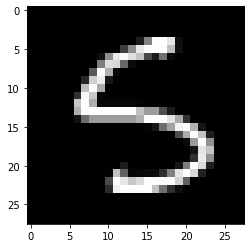

In [ ]:
plt.imshow(train_imgs[50][0], cmap='gray')

In [ ]:
X_train = []
Y_train = []
for img, y in tqdm(train_imgs):
    X_train.append(hog(img))
    Y_train.append(y)
X_train = np.vstack(X_train)
Y_train = np.array(Y_train)

X_test = []
Y_test = []
for img, y in tqdm(test_imgs):
    X_test.append(hog(img))
    Y_test.append(y)
X_test = np.vstack(X_test)
Y_test = np.array(Y_test)

svm = SVC(kernel='rbf')
svm.fit(X_train, Y_train)
Y_hat = svm.predict(X_test)
print('accuracy:', accuracy_score(Y_test, Y_hat))

100%|██████████| 1000/1000 [00:00<00:00, 3033.25it/s]


accuracy: 0.934
